# Face Generation using DCGAN

## Topic

In this notebook I will experiment with generative AI, I will specifically be using Deep Convolutional Generative Adversarial network or DCGAN to try and generate human faces from noise data. First of all I will need to detect and crop people's faces that are present in my pictures dataset. After that I will need to use two adversarial networks: a generator that would generate fake pictures and a discriminator that would classify those generated pictures as well as real pictures to be either real or not. Finally  after training both models I will try to use the generator to make up news images based on what it has learned during the training. So let's get started !

## Objectives

- Detect human faces in pictures
- Build two adversarial networks and train them
- Produce images using the Generator network

## Summary

- Importing libraries
- Detecting and cropping faces
- The dataset
- The Discriminator
- The Generator
- Building the network
- Specifying losses
- Training the network
- Inference
- Conclusion

### Importing libraries

In [5]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import cv2
from glob import glob
import random

In [2]:
photos_files = glob('faces_dataset/*/*')

In [3]:
photos_files[:3]

['faces_dataset\\faces_dataset\\0 (1).jpeg',
 'faces_dataset\\faces_dataset\\0 (1).jpg',
 'faces_dataset\\faces_dataset\\0 (1).png']

### Detecting and croping the faces

In [5]:
for file in photos_files:
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    faces = cascade.detectMultiScale(gray)
    if len(faces) > 0:
        for i, (x, y, w, h) in enumerate(faces):
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
            face = img[y:y + h, x:x + w]
            color_face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            cv2.imwrite(f'face{random.randint(0,len(photos_files))}.jpg', color_face)


First of all I imported my dataset which has female and male pictures of different ages and races, I used the cascade classifier to detect and crop only frontal faces from the pictures and saved them to my directory.

### The dataset

In [9]:
data_dir = 'faces_cropped/'

In [10]:
def get_loaders(batch_size, img_size, data_dir):
    transform = transforms.Compose([transforms.Resize(img_size),
                                    transforms.CenterCrop(img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    d = datasets.ImageFolder(data_dir, transform=transform)
    data_loader = data.DataLoader(d, batch_size=batch_size, shuffle=True)
    return data_loader

In [11]:
batch_size = 32
img_size = 32

train_loader = get_loaders(batch_size=batch_size, img_size=img_size, data_dir=data_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

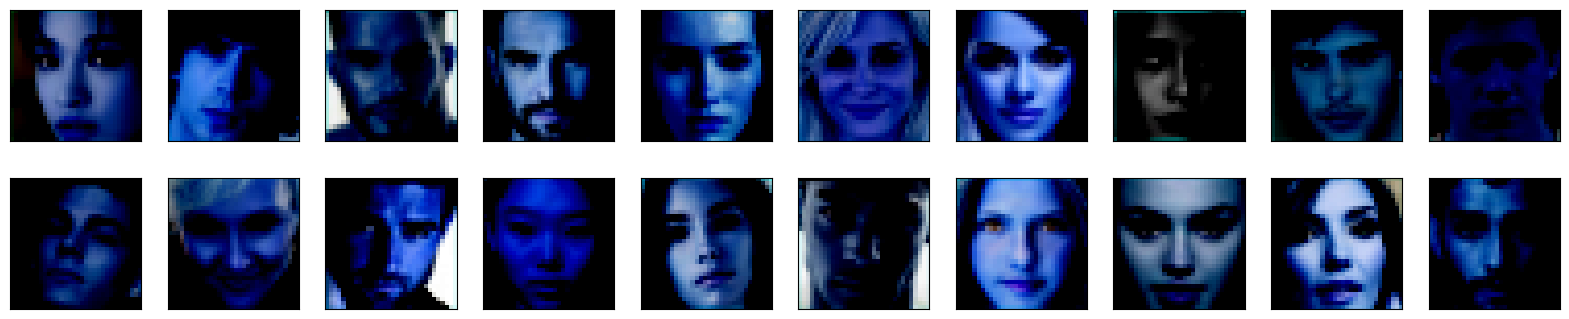

In [12]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_loader)
images, _ = next(dataiter) # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

So, I put all my cropped faces in a directory, then I passed the images through transforms to normalize them (between -1 and 1 for the tanh function in the generator that we'll use later). I created the data loader and plotted my images to have a look at them. I specifically chose the size of the pictures to be 32 by 32 because I have experimented with other bigger image shapes, but unfortunately the network crashes using them.

In [24]:
x,_ = next(iter(train_loader))
print(x.min(), x.max())
y, _ = next(iter(train_loader))
print(y.min(), y.max())

tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)


Next I just wanted to make sure that my images pixels are in the range of -1 and 1.

### The Discriminator

In [25]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = nn.Conv2d(3, self.conv_dim, 4, stride = 2, padding=1)
        self.conv2 = nn.Conv2d(self.conv_dim,self.conv_dim*2, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(self.conv_dim*2, self.conv_dim*4, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(self.conv_dim*4, self.conv_dim*8, 4, stride =2, padding=1)
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(self.conv_dim*8*2*2, 1)
        
        
        self.batchn1 = nn.BatchNorm2d(self.conv_dim)
        self.batchn2 = nn.BatchNorm2d(self.conv_dim*2)
        self.batchn3 = nn.BatchNorm2d(self.conv_dim*4)
        self.batchn4 = nn.BatchNorm2d(self.conv_dim*8)

        
    def forward(self, x):
        x = self.dropout(x)
        x= F.leaky_relu(self.batchn1(self.conv1(x)))
        x= F.leaky_relu(self.batchn2(self.conv2(x)))
        x = F.leaky_relu(self.batchn3(self.conv3(x)))
        x = F.leaky_relu(self.batchn4(self.conv4(x)))
        x = x.view(-1, self.conv_dim*8*2*2)
        x = self.fc1(x)
        return x
tests.test_discriminator(Discriminator)

Tests Passed


So, the discriminator is a classic convolutional network  where an image tensor is passed, it goes through 4 strided convolutional layers the stride of which is 4 and the padding 1, then it outputs the probability that an input is real or not (1 for real and 0 for fake)

### The Generator

In [26]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
        self.z_size = z_size
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(self.z_size, self.conv_dim*8*2*2)
        self.tconv1 = nn.ConvTranspose2d(self.conv_dim*8, self.conv_dim*4, 4, stride=2, padding=1)
        self.tconv2 = nn.ConvTranspose2d(self.conv_dim*4, self.conv_dim*2, 4, stride=2, padding=1)
        self.tconv3 = nn.ConvTranspose2d(self.conv_dim*2, self.conv_dim,4, stride=2, padding=1)
        self.tconv4 = nn.ConvTranspose2d(self.conv_dim,3, 4, stride=2, padding=1 )
        
        
        
        self.batchn1 = nn.BatchNorm2d(self.conv_dim*4)
        self.batchn2 = nn.BatchNorm2d(self.conv_dim*2)
        self.batchn3 = nn.BatchNorm2d(self.conv_dim)
        self.batchn4 = nn.BatchNorm2d(3)
        
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8,2,2)
        x = F.relu(self.batchn1(self.tconv1(x)))
        x = F.relu(self.batchn2(self.tconv2(x)))
        x = F.relu(self.batchn3(self.tconv3(x)))
        x = F.tanh(self.batchn4(self.tconv4(x)))
        return x
tests.test_generator(Generator)

Tests Passed


The generator on the other hand is a transposed convolutional network, it takes in some noise created randomly, it passes it through a fully connected layer and them passes it through transposed convolutional layers augment it and output a fake image with same size and channels as the original real images.

In [27]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if "Linear" in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.2)
        m.bias.data.fill_(0.0)
    if "conv" in classname or "BatchNorm2d" in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.2)

Next I initialized the weights for my networks, weights that are derived from a normal distribution with mean 0 and standard deviation of .2

### Building the network

In [28]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    D = Discriminator(d_conv_dim)
    G = Generator(z_size= z_size, conv_dim=g_conv_dim)
    
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)
    
    print(D)
    print()
    print(G)
    
    return D, G

In [29]:
d_conv_dim = 32
g_conv_dim = 128
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=1, bias=True)
  (batchn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (tconv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tconv2): ConvTranspose2d(512

Here I wrote a function that combines the discriminator and generator together, applied the weights to them and printed the full network.

### Specifying the losses

In [30]:
criterion = nn.BCEWithLogitsLoss()

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.8
    else:
        labels = torch.ones(batch_size)
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    loss = criterion(D_out.squeeze(), labels)
    return loss

So the loss that I used is Binary Cross Entropy with logits because I didn't use a Sigmoid activation at the end of my discriminator. The real loss is the loss calculated after a real image is passed through the network and the labels would be 1. The fake loss is the loss obtained after passing a fake image through the network and the labels for it are 0s. Then there is the smoothed real loss (smoothed by .9) which will be calculated using the fake images generated by the generator to try and fool the discriminator and see if it can classify them as real or not.

In [31]:
import torch.optim as optim
d_lr = 0.001
g_lr = 0.001
beta_1 = 0.3
beta_2 = 0.999
d_optimizer = optim.Adam(D.parameters(), lr=d_lr, betas= (beta_1,beta_2))
g_optimizer = optim.Adam(G.parameters(), lr=g_lr, betas=(beta_1, beta_2))

Next I specified the learning rate and optimizers

### Training the network

In [32]:
def train(D, G, n_epochs, print_every = 50):
    samples = []
    losses = []
    sample_size = 16
    fixed_z = np.random.uniform(-1,1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    for epoch in range(n_epochs):
        for batch_i, (real_images, _) in enumerate(train_loader):
            #real_images = scale(real_images)
            real_images = real_images.float()
            d_optimizer.zero_grad()
            r_output = D(real_images)
            r_loss = real_loss(r_output)
            
            z = np.random.uniform(-1,1, size=(sample_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
            f_output = D(fake_images)
            f_loss = fake_loss(f_output)
            
            d_loss = r_loss + f_loss
            d_loss.backward()
            d_optimizer.step()
            
            g_optimizer.zero_grad()
            z = np.random.uniform(-1,1, size=(sample_size, z_size))
            z = torch.from_numpy(z).float()
            fake = G(z)
            fake_output = D(fake)
            g_loss = real_loss(fake_output, True)
            g_loss.backward()
            g_optimizer.step()
            
            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
                
        G.eval()
        with torch.no_grad():
            sample_z = G(fixed_z)
            sample_z = sample_z.detach()
            samples.append(sample_z)
        G.train()
    with open('GAN_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    return losses

In [33]:
n_epochs = 30

losses = train(D, G, n_epochs)

Epoch [    1/   30] | d_loss: 1.4511 | g_loss: 0.5921
Epoch [    1/   30] | d_loss: 1.2348 | g_loss: 1.6940
Epoch [    2/   30] | d_loss: 1.2704 | g_loss: 1.3877
Epoch [    2/   30] | d_loss: 1.4105 | g_loss: 0.8958
Epoch [    3/   30] | d_loss: 1.7816 | g_loss: 0.8711
Epoch [    3/   30] | d_loss: 1.3205 | g_loss: 0.7113
Epoch [    4/   30] | d_loss: 1.2853 | g_loss: 1.0092
Epoch [    4/   30] | d_loss: 1.3020 | g_loss: 1.0609
Epoch [    5/   30] | d_loss: 1.1571 | g_loss: 0.8528
Epoch [    5/   30] | d_loss: 1.3502 | g_loss: 0.8332
Epoch [    6/   30] | d_loss: 1.3058 | g_loss: 1.2686
Epoch [    6/   30] | d_loss: 1.2250 | g_loss: 0.9795
Epoch [    7/   30] | d_loss: 1.2796 | g_loss: 1.1803
Epoch [    7/   30] | d_loss: 1.3973 | g_loss: 1.0226
Epoch [    8/   30] | d_loss: 1.1728 | g_loss: 1.2634
Epoch [    8/   30] | d_loss: 1.3486 | g_loss: 1.1513
Epoch [    9/   30] | d_loss: 1.1164 | g_loss: 1.0378
Epoch [    9/   30] | d_loss: 0.9137 | g_loss: 0.9890
Epoch [   10/   30] | d_loss

So the training happed over 30 epochs, during each epoch I passed in real images through the discriminator and passed some fake images created by the generator as well, I calculated the both real and fake errors, added them together and ran the optimizer to improve the gradients of the disciminator. The second part was to generate fake images using the generator, but this times passed them through the dicriminator as if they were real and calculated the loss accordingly, this means that I gave a fake picture to the discriminator and told it that it was real and calculated the loss then backpropagated through it to update the generator's gradients. 

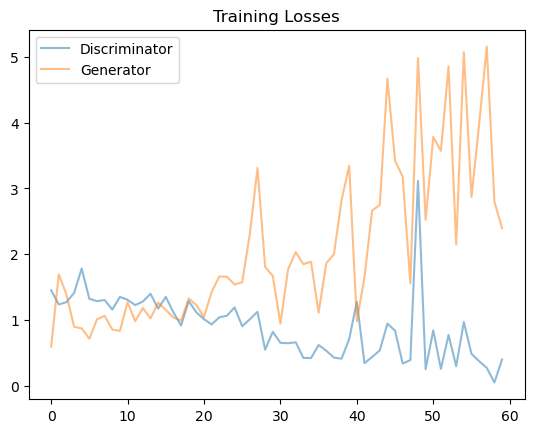

In [34]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

The losses plot shows that the discriminator's loss is fairly lower than the generator's which is completely logical seen as the generator's job is much harder than that of the disciminator.

### Inference

In [42]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
        plt.savefig('GAN faces.png')

In [43]:
with open('GAN_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

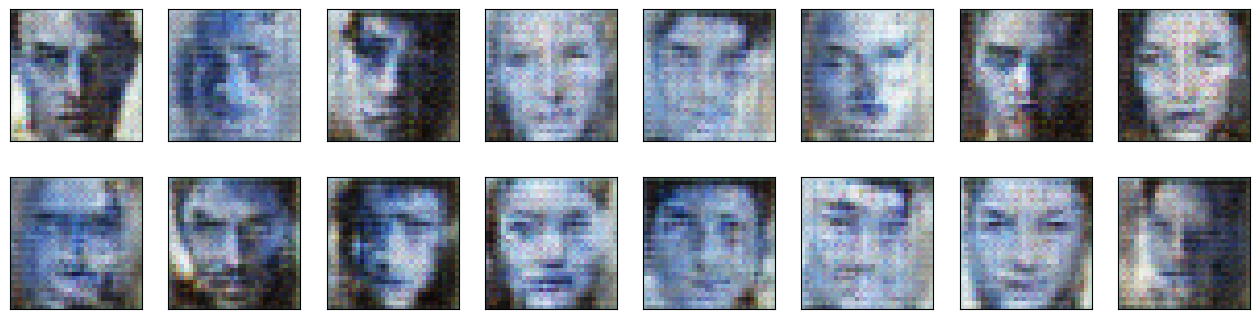

In [44]:
_ = view_samples(-1, samples)

Finally I plotted the results of the generator. Well the results are not as good as I excpected (The images are blurry with very low resolution) but I guess that's because I used low resolution images to begin with but that the only size of images that my network would accept. But all in all this experiment was fun !

## Conclusion

In this notebook I had the opportunity to work with generative AI, I used people's faces as a dataset and created an adversarial network composed of a generator that creates fake images and a discriminator that tells wether the images fed to it are real or fake. Both networks are trained simultaneously and the results of the generator are plotted at the end.